# Main notebook for "Fiscal and Monetary Policy with Heterogeneous Agents"
This notebook reads in the HA calibration in `hh_params.json` produced by `Annual Review hh calibration.ipynb`, and produces the main results of the paper, including Figures 2 and 3. It uses the household blocks (for the HA, TA, and RA models) specified in the `household.py` module, included in the same repository.

Start with preliminary imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json

import sequence_jacobian as sj # sequence-space Jacobian toolkit

from household import hh_ha, hh_ta, hh_ra

Uncomment the second line below if you want plots with exactly the same style as in the paper (note that this may take longer to render or have compatibility issues):

In [2]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})
# plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

# 1. Blocks for general equilibrium economy
Household blocks are specified in `household.py`. We now define blocks for the rest of the economy.

#### Production

In [3]:
@sj.simple
def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends income"""
    N = Y               # production technology (to first order, i.e. ignoring any Calvo or Rotemberg distortion)
    wN = Y / mu
    div = Y - wN
    return N, wN, div

#### Government bond structure
To accommodate all scenarios we're considering in the paper, we'll need to define several ways to calculate the real ex-post return on government bonds, which we call `r_post_bonds`. Our default is the first case, with real short-term bonds.

For all cases, we'll also return $q^{bond}$, which gives the end-of-period price of a debt security that pays 1 (in real terms) tomorrow—either a short-term bond that fully matures and pays 1 tomorrow (in which case the value today is $q^{bond}=1/(1+r)$), or a long-term bond that pays a coupon of 1 tomorrow (in which case the value today is higher). We'll need this for our default fiscal rule in the monetary shock case, which keeps the value paid out tomorrow constant in real terms.

In [4]:
@sj.simple
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real (our default assumption)"""
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.simple
def nom_ST_bonds(r_ante, pi):
    """Bond returns if bonds are short term and nominal"""
    # real return adjusted downward by any excess of expected over actual inflation
    pi_e = pi(1)
    r_post_bonds = (1 + r_ante(-1)) * (1 + pi_e(-1))/(1 + pi) - 1
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.solved(unknowns={'qbond': (0.001, 100.)}, targets=['q_res'], solver="brentq")
def real_LT_bonds(qbond, r_ante, delta):
    """Bond returns if bonds are long term and real"""
    # equation for end-of-period price q of stream of future coupons (1,delta,delta^2,...): q_res=0
    q_res = qbond - (1 + delta * qbond(+1)) / (1 + r_ante)

    # ex-post return on bonds is coupon today plus delta times value of remaining coupon stream
    # divided by yesterday's end-of-period price
    r_post_bonds = (1 + delta * qbond) / qbond(-1) - 1
    return r_post_bonds, q_res

#### Fiscal policy
The basic fiscal rule is simple: given desired paths of end-of-period debt value $B_t$ and government spending $G_t$, solve for the tax rate on all income (including labor and dividend income, which together comprise total output $Y_t$) that balances the budget. This is done in the first few lines below.

We also need several additional outputs here, though, which are used only in special cases:
1. For our implementation of Angeletos Lian Wolf ("ALW" 2024), we calculate the residual of the tax *rate* relative to an exogenously shocked path. 

2. For our implementation of either the FTPL or of a slow-moving fiscal rule that raises taxes gradually in response to higher debt, we calculate the residual of overall tax *revenue* relative to a rule that can be shocked. 

3. For our default fiscal rule in response to monetary shocks, we calculate $B_t/q_t$, which is the real amount paid at $t+1$ (the coupon for long-term debt, entire maturing bond for short-term debt), and then calculate the residual of that vs. a constant.

In all these three cases, we will ultimately solve for the path of $B_t$ that sets the relevant residual to zero.

In [5]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock
    
    # Tax revenue rule (used for FTPL and alternative fiscal rule)
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock
    
    # Default fiscal rule for monetary policy: constant amount owed tomorrow
    constant_owed_res = B/qbond - B.ss/qbond.ss
    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

We also have a slight variation on the main case above, where any deviation of desired taxes from steady state is assessed lump-sum on the agents in the highest income state.

In [6]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden
    T = Tax_total.ss                                # fix standard proportional taxes at steady state level
    Tax_richest = Tax_total - T                     # remaining tax burden assessed on richest
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

#### Capitalized value of firms and asset returns
The following blocks calculates the end-of-period value $p_t$ of firms, which is the capitalized value of future dividends, and then uses this to calculate both the ex-post return on firms and the ex-post return on all assets in the economy.

In [7]:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond'])
def capitalization(div_aftertax, r_ante, p):
    """Calculate end-of-period value p of firm and ex-post return on equity holdings"""
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

@sj.simple
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets, combining equity and bond returns"""
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

#### New Keynesian Phillips curve
The following is a standard New Keynesian Phillips curve (valid to first order), equation (2) in the article.

Note that, rather than outputing inflation directly, this block outputs the residual of the NKPC, which is then set as a target (with inflation as an unknown) in the subset of cases where we need to solve for inflation.

In [8]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis) # using C = Y-G
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

#### Taylor rule
In most experiments, we set the path of real rates exogenously, but when we use a Taylor rule instead (either active or, in the FTPL case, passive), we'll add this block:

In [9]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

#### Market clearing
We'll generally use asset market clearing to solve for equilibrium, since it is more robust, but it will be a good cross-check to also look at goods market clearing, which should be zero by Walras's law:

In [10]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""
    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

#### Assembling full models
We put our typical set of non-household blocks in the `common_blocks` list, and then specify models that combine these blocks with the HA, TA, and RA household blocks (taken from `household.py`).

For some model variants, we'll later need to replace blocks in, or add blocks to, `common_blocks`.

In [11]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

# 2. Calibration of general equilibrium economy
We start by specifying core parameters for all models. We need to solve for the markup `mu` so that asset supply is consistent with our calibration of total household assets, but this is simple enough that we can do it by hand:

In [12]:
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending 
C = Y - G       # remaining 80% is consumption

tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu

1.1142857142857143

We can similarly solve for the scale on labor disutility so that $Y=N=1$ is consistent with zero steady-state inflation. As with `mu`, we could do this using the toolkit, but it's simple enough that we can do it by hand:

In [13]:
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch) # implied parameter scaling wage disutility for zero steady-state pi

Now we store general equilibrium parameters that will be required for all models:

In [14]:
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule)
            T_shock = 0,           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            T_rule_coeff = 0,      # Coefficient in tax revenue rule on debt (only used with slow adjustment)
            )

We now calculate steady states of the HA, RA, and TA models one-by-one, and check market clearing (in addition to the budget constraint and Euler equations for RA and TA) and the New Keynesian Phillips curve residual to make sure we didn't make any mistakes in reasoning about the calibration:

In [15]:
ss = {}

We start with the HA model, where we separately calibrated the household side in `Annual Review hh calibration.ipynb` and now just need to load the saved parameters:

In [16]:
with open('hh_params.json') as f:
    ha_params = json.load(f)

ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res']

(1.8641088672666228e-11, 5.881724058909299e-07, -2.220446049250313e-18)

For the RA model, the only parameter we need to calculate is $\beta = 1/(1+r)$:

In [17]:
beta = 1 / (1 + r)
ra_params = dict(beta=beta, beta_ave=beta)
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

For the TA model, we additionally need to calculate the share $\lambda$ of hand-to-mouth agents to hit an MPC target of 0.2, as well as the consumption of the unconstrained agent (`C_RA`).

In [18]:
beta = 1 / (1 + r)
lam = 0.2 - r / (1+r)
C_RA = (C - lam * w_post) / (1 - lam)
ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)
ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

#### Caching pre-calculate household Jacobians
To save a bit of time, it is useful to pre-calculate Jacobians for the heterogeneous-agent household block, which we can then feed in to `solve_impulse_linear` using the `Js=` argument, so that the toolkit does not re-calculate these Jacobians under the hood every time.

In [19]:
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], T=T)}
hh_ha.name # verify that 'hh_ha' is the name of the het-agent household block

'hh_ha'

# 3. Deficit-financed tax cuts
First, let's construct the tax cut shock as described in the paper:

In [20]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

### 3(i). Baseline case: comparing HA, TA, RA
Here, we construct **Figure 2(a)**. For each model, we solve for the path of output `Y` as an unknown, in order to hit the asset-market clearing target:

In [21]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y'], targets=['asset_mkt'],
                                            inputs={'B': dB}, outputs=['Y'], Js=Js)['Y'] for k in model_names}

Note: If we were interested in the inflation response to the tax cut here, we would have to add `pi` to the unknowns and `nkpc_res` to the targets in the `solve_impulse_linear` call above. We will do this in the monetary policy shock case below when analyzing the Taylor rule. There, inflation matters directly for the output response.

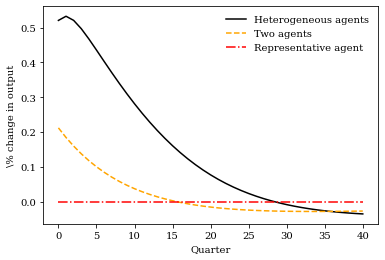

In [22]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

### 3(ii). Alternative assumptions and policy rules
We now perform, in the same order they are listed, the alternative experiments in Figure 2(b) and Figure 4(b), 

#### Tax changes at margin on highest earners

In [23]:
# replace regular fiscal rule with rule that taxes the richest at the margin
common_blocks_richest = common_blocks.copy()
common_blocks_richest[2] = fiscal_richest
model_ha_richest = sj.combine(common_blocks_richest + [hh_ha])

irf_B_richest = model_ha_richest.solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                                      inputs={'B': dB}, outputs=['Y'])['Y']

#### Taylor rule
For this rule, we need to calculate inflation `pi` as an additional unknown, adding the NKPC residual as an additional target. We also need to add the `taylor_rule` block to the model, specifying its additional parameters.

In [24]:
ss_taylor = ss['ha'].copy()
ss_taylor['phi'], ss_taylor['rstar'] = 1.5, r
model_ha_taylor = sj.combine(common_blocks + [hh_ha, taylor_rule])
irf_B_taylor = model_ha_taylor.solve_impulse_linear(ss_taylor, unknowns=['Y', 'pi'], targets=['asset_mkt', 'nkpc_res'],
                                               inputs={'B': dB}, outputs=['Y'], Js=Js)['Y']

#### Angeletos-Lian-Wolf tax rate rule
For this rule, total debt $B$ is endogenously determined subject to a rule that sets the tax rate equal to the steady state plus some shock (which we enforce by setting the previously defined `tax_rate_res` residual to zero):

In [25]:
irf_B_ALW = models['ha'].solve_impulse_linear(ss['ha'], unknowns=['Y', 'B'], targets=['asset_mkt', 'tax_rate_res'],
                                             inputs={'tax_rate_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']


#### Figure 2(b)
We summarize the additional results we've obtained so far in Figure 2(b):

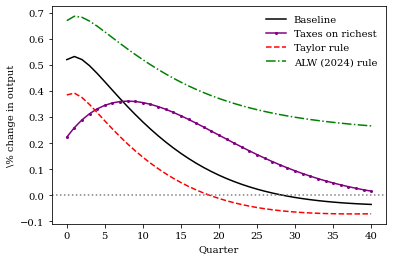

In [26]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2b_deficit_alternative_rules.pdf', bbox_inches='tight')

#### HANK-FTPL
This combines elements of the Taylor rule case and ALW case above. We now set a Taylor rule coefficient of zero ("passive" monetary policy), replace the previous government debt block with nominal debt, and have bonds $B$ determined endogenously by a rule that exogenously shocks total government tax revenue (and thus primary surpluses).

In [27]:
ss_ftpl = ss_taylor.copy()
ss_ftpl['phi'] = 0
common_blocks_nomdebt = common_blocks.copy()
common_blocks_nomdebt[1] = nom_ST_bonds
model_ha_ftpl = sj.combine(common_blocks_nomdebt + [hh_ha, taylor_rule])
irf_B_FTPL_nomdebt =model_ha_ftpl.solve_impulse_linear(ss_ftpl, unknowns=['Y', 'pi', 'B'],
                                            targets=['asset_mkt', 'nkpc_res', 'T_res'],
                                            inputs={'T_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']


#### Myopic households
We modify our pre-calculated Jacobians by hand to make them "myopic" (so that every shock is treated as a surprise, and has the same reaction as in the 0th column), and then feed these new Jacobians into `Js`:

In [28]:
# Make Jacobians myopic: Copy the first column down along the diagonal
jac_ = {}
for o in ['C', 'A']:
    jac_[o] = {}
    for i in ['wN_aftertax', 'N', 'r']:
        jac_[o][i] = np.tril(scipy.linalg.toeplitz(Js['hh_ha'][o, i][:, 0])) # first column repeated along diagonal
        
Js_myopic = {'hh_ha': sj.JacobianDict(jac_, inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], name='hh')}

# currently a bug in sequence_jacobian where impulse_linear doesn't pass through Js on hetblocks, will fix ASAP!
# irf_B_myopic = models['ha'].solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
#                                                 inputs={'B': dB}, Js={'hh': jac_myopic}, outputs=['Y'])['Y']

irf_B_myopic = (models['ha'].solve_jacobian(ss['ha'], unknowns=['Y'], targets=['asset_mkt'], T=T,
                                        Js=Js_myopic, inputs=['B'], outputs=['Y']) @ {'B': dB})['Y']

#### Nonlinear response

In [29]:
# nonlinearity
irf_B_nonlinear = models['ha'].solve_impulse_nonlinear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                    inputs={'B': dB*0.01}, outputs=['Y'], Js=Js)['Y']*100

Solving real_ST_bonds_to_nkpc_combined for ['Y'] to hit ['asset_mkt']
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 8.88E-04
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 0
   max error for asset_mkt is 3.13E-02
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.44E-03
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 1
   max error for asset_mkt is 2.31E-04
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.45E-03
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 2
   max error for asset_mkt is 1.53E-06
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.45E-03
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 3
   max error for asset_mkt is 3.48E-08
Solving capitalization_inner for ['p'] to hit ['cap_co

#### Figure 4(b)

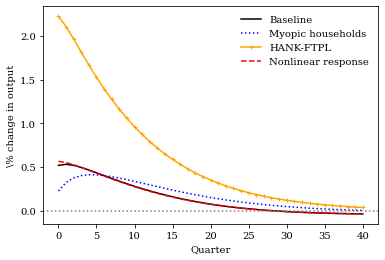

In [30]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_myopic[:41], label='Myopic households', linestyle='dotted', color='blue')
plt.plot(irf_B_FTPL_nomdebt[:41], label='HANK-FTPL', linestyle='-', color='orange', marker='+', markersize=4)
plt.plot(irf_B_nonlinear[:41], label='Nonlinear response', linestyle='dashed', color='red')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure4b_deficit_extensions.pdf', bbox_inches='tight')

# 4. Monetary policy shock

First, let's specify our main monetary policy experiment, an exogenous cut to the real interest rate:

In [31]:
dr = -0.25 * 0.9**np.arange(T)
shock_r = {'r_ante': dr}

### 4(i). Baseline monetary policy exercise
First we'll compute impulse responses for our baseline monetary policy exercise.

We choose the fiscal response by setting `constant_owed_res` to zero as a target, which endogenously determines `B` so that, going into the next period, the total real cash flow owed by the government is always constant. We can think of this as a very rapid fiscal response to interest rates:

In [32]:
irfs_r = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y', 'B'], targets=['asset_mkt', 'constant_owed_res'],
                                inputs=shock_r, outputs=['Y', 'r', 'wN', 'wN_aftertax'], Js=Js) for k in model_names}

#### Figure 3(a)

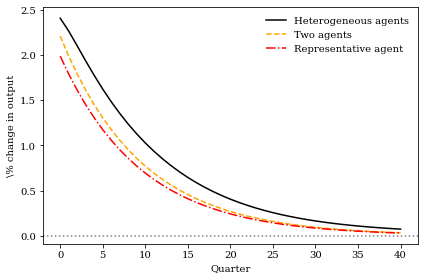

In [33]:
plt.plot(irfs_r['ha']['Y'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_r['ta']['Y'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_r['ra']['Y'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.tight_layout()
plt.savefig('figures/figure3a_monetary_by_model.pdf')

#### Figure 3(b): decomposition
Now, we use the household Jacobians we've calculated to get contributions to consumption (and, in this case, therefore output) from all individual sources.

First, the "capital gains" effect is the response to the unexpected change in ex-post $r_0$, while the effect of ex-ante interest rates corresponds to the change in ex-post $\{r_1,r_2,\ldots\}$. Then 

In [34]:
dC_cap_gains = Js['hh_ha']['C','r'][:, 0] * irfs_r['ha']['r'][0]
dC_r = Js['hh_ha']['C','r'][:, 1:] @ irfs_r['ha']['r'][1:]
dC_labor = Js['hh_ha']['C', 'wN_aftertax'] @ irfs_r['ha']['wN']
dC_tax = Js['hh_ha']['C', 'wN_aftertax'] @ (irfs_r['ha']['wN_aftertax'] - irfs_r['ha']['wN'])
assert np.allclose(dC_cap_gains + dC_r + dC_labor + dC_tax, irfs_r['ha']['Y'])

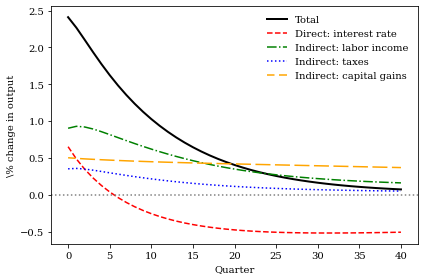

In [35]:
plt.plot(irfs_r['ha']['Y'][:41], label='Total', color='black', linewidth=2)
plt.plot(dC_r[:41], label='Direct: interest rate', linestyle='dashed', color='red')
plt.plot(dC_labor[:41], label='Indirect: labor income', linestyle='dashdot', color='green')
plt.plot(dC_tax[:41], label='Indirect: taxes', linestyle='dotted', color='blue')
plt.plot(dC_cap_gains[:41], label='Indirect: capital gains', linestyle=(5, (10, 3)), color='orange')
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.legend(frameon=False)
plt.tight_layout()
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.tight_layout()
plt.savefig('figures/figure3b_monetary_decomposition.pdf')

### 4(ii). Alternative assumptions for monetary policy

#### Slow fiscal adjustment
We implement slow fiscal adjustment by instead targeting the `T_res` residual of a rule that adjusts taxes by a small amount in response to debt being away from steady state:

In [36]:
ss_slow = ss['ha'].copy()
ss_slow['T_rule_coeff'] = 0.02
irf_r_altfiscal = models['ha'].solve_impulse_linear(ss_slow, unknowns=['Y', 'B'], targets=['asset_mkt', 'T_res'],
                                                    inputs=shock_r, outputs=['Y'], Js=Js)['Y']

#### Long-term debt
To implement long-term debt (still real), we replace the relevant government bond block by `real_LT_bonds` and regenerate the model.

In [37]:
common_blocks_LTdebt = common_blocks.copy()
common_blocks_LTdebt[1] = real_LT_bonds
model_ha_LTdebt = sj.combine(common_blocks_LTdebt + [hh_ha])

# recalculate steady state to get correct qbond
ss_LTdebt = model_ha_LTdebt.steady_state({**ss['ha'], 'delta': 0.95})
assert np.allclose([ss_LTdebt['asset_mkt'], ss_LTdebt['goods_mkt'], ss_LTdebt['nkpc_res']], [0, 0, 0], atol=1e-6)

irf_r_LTdebt = model_ha_LTdebt.solve_impulse_linear(ss_LTdebt, unknowns=['Y', 'B'], 
                        targets=['asset_mkt', 'constant_owed_res'], inputs=shock_r, outputs=['Y'], Js=Js)['Y']

#### Nominal debt
We have already implemented nominal (short-term) debt as part of our FTPL exercise. We'll reuse the `common_blocks_nomdebt` from that exercise, and similarly solve for both `B` and `pi` in addition to `Y` as unknowns. (Now, however, we are back to our standard "constant owed tomorrow" fiscal rule.)

In [38]:
# replace bond return function
model_ha_nomdebt = sj.combine(common_blocks_nomdebt + [hh_ha])
irf_r_nomdebt = model_ha_nomdebt.solve_impulse_linear(ss['ha'], unknowns=['Y', 'B', 'pi'],
                    targets=['asset_mkt', 'constant_owed_res', 'nkpc_res'], inputs=shock_r, outputs=['Y'], Js=Js)['Y']

### Alternative cyclicality of income

In [39]:
ss_countercyc = ss['ha'].copy()
ss_countercyc['zeta'] = -0.15 # don't use precalculated Js here, since zeta != 0 should change them
irf_r_countercyc = models['ha'].solve_impulse_linear(ss_countercyc, unknowns=['Y', 'B'], targets=['asset_mkt', 'constant_owed_res'], inputs=shock_r, outputs=['Y'])['Y']

### Plot results

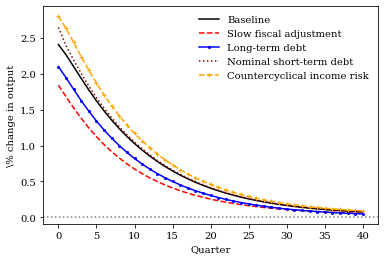

In [40]:
plt.plot(irfs_r['ha']['Y'][:41], label='Baseline', color='black')
plt.plot(irf_r_altfiscal[:41], label='Slow fiscal adjustment', linestyle='dashed', color='red')
plt.plot(irf_r_LTdebt[:41], label='Long-term debt',  linestyle='-', color='blue', marker='o', markersize=2)
plt.plot(irf_r_nomdebt[:41], label='Nominal short-term debt',  linestyle='dotted', color='darkred')
plt.plot(irf_r_countercyc[:41], label='Countercyclical income risk', linestyle='dashed', color='orange', marker='+', markersize=4)

plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure4a_monetary_extensions.pdf', bbox_inches='tight')